memory management

split-reward-training
- pretrain       77.32  +-  4.55
- scratch        72.16  +-  4.24

no-split-reward-training
- pretrain       79.8  +-  4.18
- scratch        75.68  +-  5.25

In [ ]:
import random
import logging

logger = logging.getLogger()
logger.disabled = True

import numpy as np
from tqdm.auto import tqdm

from agent import HandcraftedAgent


capacity = {"episodic": 16, "episodic_agent": 16, "semantic": 16, "short": 1}


room_size = {
    "room_config": {
        "officeroom": {
            "north": "wall",
            "east": "livingroom",
            "south": "wall",
            "west": "wall",
        },
        "livingroom": {
            "north": "wall",
            "east": "wall",
            "south": "wall",
            "west": "officeroom",
        },
    },
    "object_transition_config": {
        "static": {"desk": None},
        "independent": {
            "tae": {
                "officeroom": {
                    "north": 0,
                    "east": 1.0,
                    "south": 0,
                    "west": 0,
                    "stay": 0,
                },
                "livingroom": {
                    "north": 0,
                    "east": 0,
                    "south": 0,
                    "west": 1.0,
                    "stay": 0,
                },
            },
        },
        "dependent": {
            "laptop": {"tae": 1.0},
        },
        "agent": {"agent": {"officeroom": None, "livingroom": None}},
    },
    "object_init_config": {
        "static": {
            "desk": {"officeroom": 1, "livingroom": 0},
        },
        "independent": {
            "tae": {"officeroom": 1.0, "livingroom": 0},
        },
        "dependent": {
            "laptop": {"officeroom": 1.0, "livingroom": 0},
        },
        "agent": {"agent": {"officeroom": 1.0, "livingroom": 0, "bedroom": 0}},
    },
}
config = {
    "question_prob": 1.0,
    "terminates_at": 99,
    "room_size": room_size,
}
results = {}

for mm_policy in ["random", "generalize"]:
    for qa_policy in ["random", "episodic_semantic"]:
        for explore_policy in ["random", "avoid_walls"]:
            for pretrain_semantic in [True, False]:
                key = (
                    mm_policy,
                    qa_policy,
                    explore_policy,
                    pretrain_semantic,
                )
                if key not in results:
                    results[key] = []
                print(key)

                for seed in tqdm([0, 1, 2, 3, 4]):
                    config["seed"] = seed

                    agent = HandcraftedAgent(
                        env_str="room_env:RoomEnv-v2",
                        env_config=config,
                        mm_policy=mm_policy,
                        qa_policy=qa_policy,
                        explore_policy=explore_policy,
                        num_samples_for_results=10,
                        capacity=capacity,
                        pretrain_semantic=pretrain_semantic,
                    )
                    agent.test()
                    agent.remove_results_from_disk()
                    to_append = (np.mean(agent.scores), np.std(agent.scores))
                    # print(to_append)
                    results[key].append(to_append)

In [11]:
print(
    f"{'memory mgmt':<20}{'qa':<20}{'explore':<20}{'pretrain_semantic':<20}{'mean':<10}{'std':<10}"
)
print(f"-" * 110)
for key, val in results.items():
    print(
        f"{str(key[0]):<20}{str(key[1]):<20}{str(key[2]):<20}{str(key[3]):<20}{round(np.mean([v[0] for v in val]), 2):<10}{round(np.std([v[0] for v in val]), 2):<10}"
    )

memory mgmt         qa                  explore             pretrain_semantic   mean      std       
--------------------------------------------------------------------------------------------------------------
random              random              random              True                43.32     1.72      
random              random              random              False               43.32     1.72      
random              random              avoid_walls         True                50.84     5.11      
random              random              avoid_walls         False               50.84     5.11      
random              episodic_semantic   random              True                58.24     2.91      
random              episodic_semantic   random              False               58.24     2.91      
random              episodic_semantic   avoid_walls         True                59.48     2.81      
random              episodic_semantic   avoid_walls         False               5

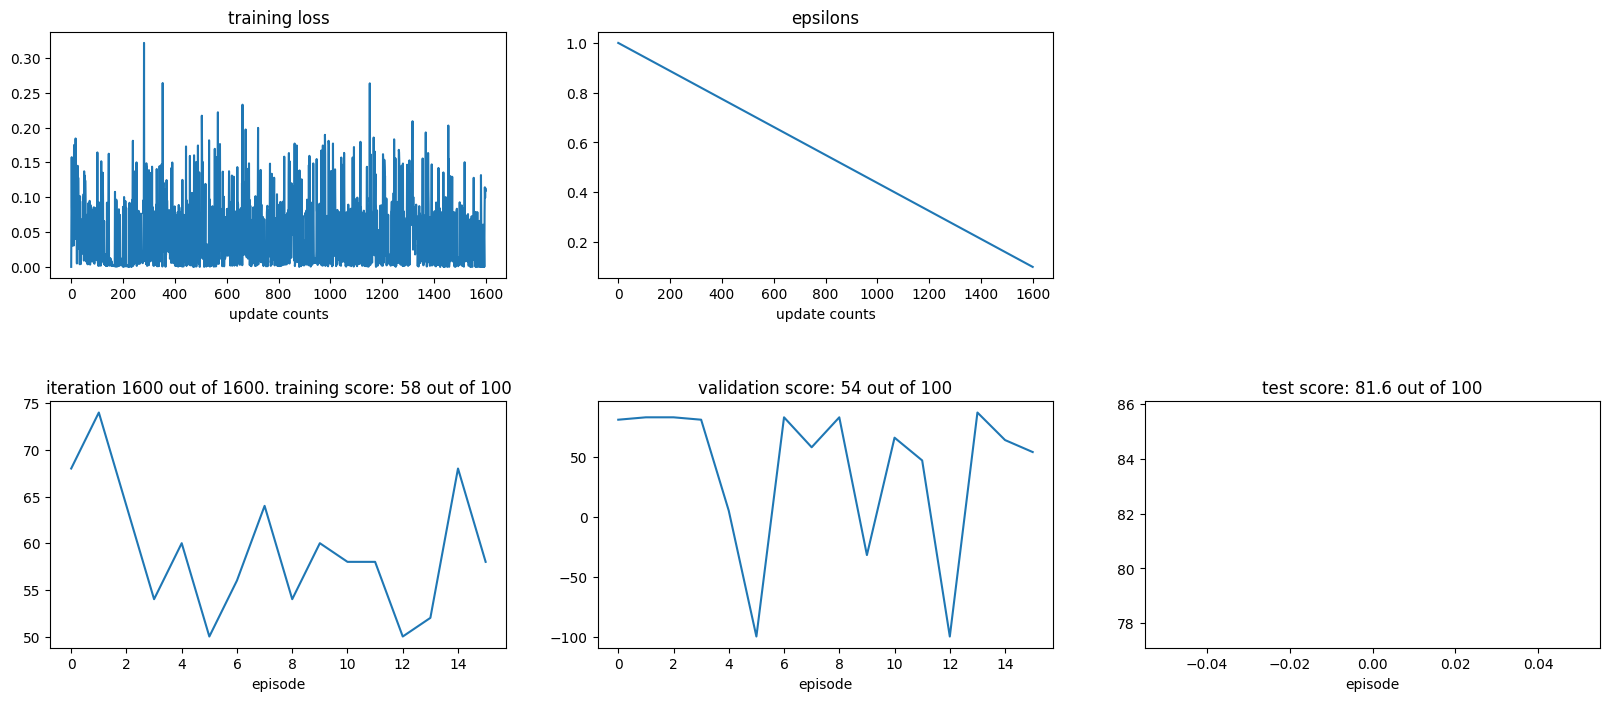

In [1]:
import logging

logger = logging.getLogger()
logger.disabled = True

from agent.dqn import DQNExploreAgent, DQNMMAgent

for pretrain_semantic in [False, True]:
    for test_seed in [0, 1, 2, 3, 4]:
        for randomize_order in [True, False]:
            all_params = {
                "env_str": "room_env:RoomEnv-v2",
                "max_epsilon": 1.0,
                "min_epsilon": 0.1,
                "epsilon_decay_until": 100 * 16,
                "gamma": 0.65,
                "capacity": {
                    "episodic": 16,
                    "episodic_agent": 16,
                    "semantic": 16,
                    "short": 1,
                },
                "nn_params": {
                    "hidden_size": 64,
                    "num_layers": 2,
                    "embedding_dim": 32,
                    "v1_params": None,
                    "v2_params": {},
                    "memory_of_interest": [
                        "episodic",
                        "episodic_agent",
                        "semantic",
                        "short",
                    ],
                },
                "num_iterations": 100 * 16,
                "replay_buffer_size": 128,
                "warm_start": 128,
                "batch_size": 16,
                "target_update_rate": 10,
                "pretrain_semantic": pretrain_semantic,
                "run_validation": True,
                "run_test": True,
                "num_samples_for_results": 10,
                "train_seed": test_seed + 5,
                "plotting_interval": 10,
                "device": "cpu",
                "test_seed": test_seed,
                # "mm_policy": "generalize",
                "qa_policy": "episodic_semantic",
                "explore_policy": "avoid_walls",
                "env_config": {
                    "question_prob": 1.0,
                    "terminates_at": 99,
                    "randomize_order": randomize_order,
                    "room_size": {
                        "room_config": {
                            "officeroom": {
                                "north": "wall",
                                "east": "livingroom",
                                "south": "wall",
                                "west": "wall",
                            },
                            "livingroom": {
                                "north": "wall",
                                "east": "wall",
                                "south": "wall",
                                "west": "officeroom",
                            },
                        },
                        "object_transition_config": {
                            "static": {"desk": None},
                            "independent": {
                                "tae": {
                                    "officeroom": {
                                        "north": 0,
                                        "east": 1.0,
                                        "south": 0,
                                        "west": 0,
                                        "stay": 0,
                                    },
                                    "livingroom": {
                                        "north": 0,
                                        "east": 0,
                                        "south": 0,
                                        "west": 1.0,
                                        "stay": 0,
                                    },
                                },
                            },
                            "dependent": {
                                "laptop": {"tae": 1.0},
                            },
                            "agent": {
                                "agent": {"officeroom": None, "livingroom": None}
                            },
                        },
                        "object_init_config": {
                            "static": {
                                "desk": {"officeroom": 1, "livingroom": 0},
                            },
                            "independent": {
                                "tae": {"officeroom": 1.0, "livingroom": 0},
                            },
                            "dependent": {
                                "laptop": {"officeroom": 1.0, "livingroom": 0},
                            },
                            "agent": {
                                "agent": {
                                    "officeroom": 1.0,
                                    "livingroom": 0,
                                    "bedroom": 0,
                                }
                            },
                        },
                    },
                },
                "ddqn": False,
                "dueling_dqn": False,
                "split_reward_training": False,
            }

            agent = DQNMMAgent(**all_params)
            agent.train()

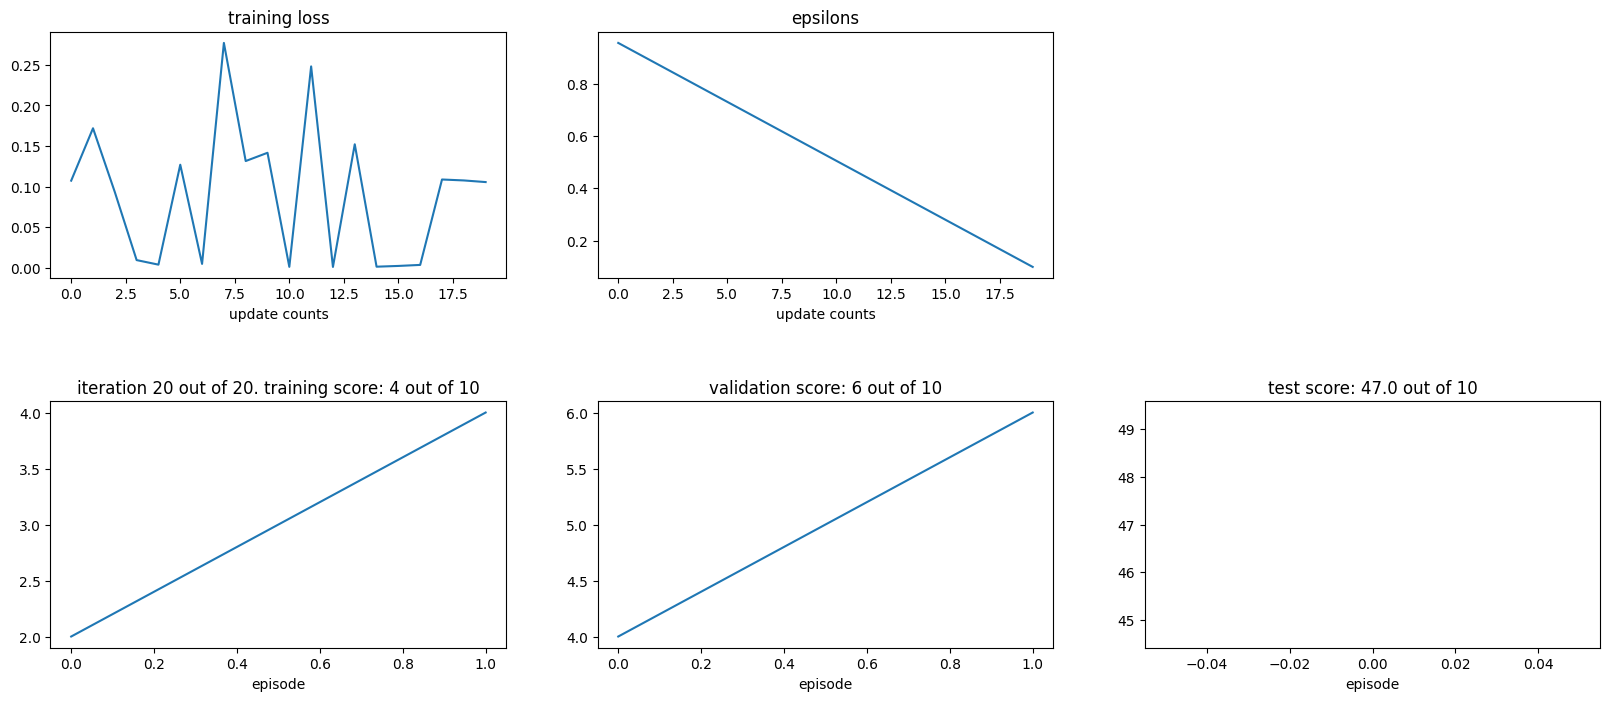

In [ ]:
import logging

logger = logging.getLogger()
logger.disabled = True

from agent.dqn import DQNExploreAgent, DQNMMAgent

# all_params = {
#     "env_str": "room_env:RoomEnv-v2",
#     "max_epsilon": 1.0,
#     "min_epsilon": 0.1,
#     "epsilon_decay_until": 100 * 16,
#     "gamma": 0.65,
#     "capacity": {"episodic": 16, "episodic_agent": 16, "semantic": 16, "short": 1},
#     "nn_params": {
#         "hidden_size": 64,
#         "num_layers": 2,
#         "embedding_dim": 32,
#         "v1_params": None,
#         "v2_params": {},
#         "memory_of_interest": ["episodic", "episodic_agent", "semantic", "short"],
#     },
#     "num_iterations": 100 * 16,
#     "replay_buffer_size": 1024 * 100,
#     "warm_start": 1024 * 100,
#     "batch_size": 1024,
#     "target_update_rate": 10,
#     "pretrain_semantic": False,
#     "run_validation": True,
#     "run_test": True,
#     "num_samples_for_results": 10,
#     "train_seed": 5,
#     "plotting_interval": 10,
#     "device": "cpu",
#     "test_seed": 0,
#     "qa_policy": "episodic_semantic",
#     "explore_policy": "avoid_walls",
#     "env_config": {
#         "question_prob": 1.0,
#         "terminates_at": 99,
#         "room_size": "dev",
#     },
#     "ddqn": True,
#     "dueling_dqn": True,
#     "split_reward_training": False,
# }

all_params = {
    "env_str": "room_env:RoomEnv-v2",
    "max_epsilon": 1.0,
    "min_epsilon": 0.1,
    "epsilon_decay_until": 10 * 2,
    "gamma": 0.65,
    "capacity": {"episodic": 16, "episodic_agent": 16, "semantic": 16, "short": 1},
    "nn_params": {
        "hidden_size": 64,
        "num_layers": 2,
        "embedding_dim": 32,
        "v1_params": None,
        "v2_params": {},
        "memory_of_interest": ["episodic", "episodic_agent", "semantic", "short"],
    },
    "num_iterations": 10 * 2,
    "replay_buffer_size": 16,
    "warm_start": 4,
    "batch_size": 4,
    "target_update_rate": 10,
    "pretrain_semantic": False,
    "run_validation": True,
    "run_test": True,
    "num_samples_for_results": 2,
    "train_seed": 5,
    "plotting_interval": 10,
    "device": "cpu",
    "test_seed": 0,
    "qa_policy": "episodic_semantic",
    "explore_policy": "avoid_walls",
    "env_config": {
        "question_prob": 1.0,
        "terminates_at": 9,
        "room_size": "dev",
    },
    "ddqn": True,
    "dueling_dqn": True,
    "split_reward_training": False,
}

agent = DQNMMAgent(**all_params)
agent.train()

In [ ]:
from glob import glob
from explicit_memory.utils import read_yaml

results = {"pretrain": [], "scratch": []}
for foo in glob("./training_results/*/*train.yaml"):
    bar = read_yaml(foo)
    # print(foo, bar["test_seed"], bar["pretrain_semantic"])

    foo_ = foo.replace("train.yaml", "results.yaml")

    bar_ = read_yaml(foo_)
    if bar["pretrain_semantic"]:
        results["pretrain"].append(bar_["test_score"])
    else:
        results["scratch"].append(bar_["test_score"])


foo = [foo["mean"] for foo in results["scratch"]]
print(f"{'scratch':<15}{round(np.mean(foo), 2)}  +-  {round(np.std(foo), 2)}")

foo = [foo["mean"] for foo in results["pretrain"]]
print(f"{'pretrain':<15}{round(np.mean(foo), 2)}  +-  {round(np.std(foo), 2)}")

In [ ]:
from glob import glob
from copy import deepcopy
from explicit_memory.utils import read_yaml
import os

results = {
    "split-reward-training": {"pretrain": [], "scratch": []},
    "no-split-reward-training": {"pretrain": [], "scratch": []},
}

for foo in deepcopy(glob("./training_results/mm/*/train.yaml")):
    baz = foo.replace("train.yaml", "results.yaml")
    bar = read_yaml(foo)
    qux = read_yaml(baz)
    if bar["split_reward_training"]:
        if bar["pretrain_semantic"]:
            results["split-reward-training"]["pretrain"].append(
                qux["test_score"]["mean"]
            )
        else:
            results["split-reward-training"]["scratch"].append(
                qux["test_score"]["mean"]
            )
    else:
        if bar["pretrain_semantic"]:
            results["no-split-reward-training"]["pretrain"].append(
                qux["test_score"]["mean"]
            )
        else:
            results["no-split-reward-training"]["scratch"].append(
                qux["test_score"]["mean"]
            )

In [ ]:
import numpy as np

for key, val in results.items():
    print(f"{key}")
    for key_, val_ in val.items():
        print(f"  {key_:<15}{round(np.mean(val_), 2)}  +-  {round(np.std(val_), 2)}")

split-reward-training
  pretrain       77.32  +-  4.55
  scratch        72.16  +-  4.24
no-split-reward-training
  pretrain       79.8  +-  4.18
  scratch        75.68  +-  5.25


In [ ]:
qux["test_score"]

{'mean': 78.6, 'std': 8.49}

In [ ]:
baz

NameError: name 'baz' is not defined

In [ ]:
bar["split_reward_training"]

False

In [ ]:
bar["pretrain_semantic"]

True

In [ ]:
len(glob("./training_results/*/results.yaml"))

20